<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/mlp_eeg_Pavel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import backend as K
import keras.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import math
import os
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
###Added
import seaborn as sns
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor

Обработка данных

In [ ]:
sfq = 250
wnd = 1
bias = 2
times = 12

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
class CrossWindow():
  
  def __init__(self, arr, n, add_tail=False):
    assert len(arr.shape) == 1
    sh = arr.shape[0]
    assert n < sh
    if sh%n == 0:
        self.arr = arr.reshape(n, sh//n)
    else:
        if add_tail:
            print(f'Warning: impossible to fit array in shape ({n}, {sh//n}), remaining tail will have size {sh%n}')
            self.arr = arr[:n*sh//n].reshape(n, sh//n)
        

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def coeff_determination_simp(y_true, y_pred):
    res = np.sum(np.square(y_true - y_pred))
    y_true_mean = np.tile(np.mean(y_true, axis=-1), y_true.shape[-1]).reshape((y_true.shape[-1], y_true.shape[-2])).T
    tot = np.sum(np.square(y_true - y_true_mean))
    return 1 - res/((tot + K.epsilon())*y_true.shape[0]*y_true.shape[1])

In [ ]:
mapping = [
    ('O2','A2'),
    ('O1','A1'),
    ('P4','A2'),
    ('P3','A1'),
    ('C4','A2'),
    ('C3','A1'),
    ('F4','A2'),
    ('F3','A1'),
    ('Fp2','A2'),
    ('Fp1','A1'),
    ('T6','A2'),
    ('T5','A1'),
    ('T4','A2'),
    ('T3','A1'),
    ('F8','A2'),
    ('F7','A1'),
    ('Oz','A2'),
    ('Pz','A1'),
    ('Cz','A2'),
    ('Fz','A1'),
    ('Fpz','A2'),
    ('FT7','A1'),
    ('FC3','A1'),
    ('Fcz','A1'),
    ('FC4','A2'),
    ('FT8','A2'),
    ('TP7','A1'),
    ('CP3','A1'),
    ('Cpz','A1'),
    ('CP4','A2'),
    ('TP8','A2'), 
]
r_mapping = {mapping[i][0]:i for i in range(len(mapping))}
    

In [ ]:
def normalize(arr:np.array):
    return (arr - arr.min())/(arr.max()-arr.min())

In [ ]:
def extract(data_stream):
    raw_data = data_stream.readlines()
    data = []
    for line in raw_data:
        temp = np.array([float(x) for x in line.split()])
        data.append(temp)
    return np.array(data)

def format_fname(_group, _hand, _subj, _tr_num):
    directory = 'D:\\Jupyterlabs\\Assignment\\Subjects'
    fname_pattern = f'{_group}_subject_{_subj}_{_hand}_tr_{_tr_num}.dat'
    return join(directory, fname_pattern)

hands = ('lefthand', 'righthand')
groups = ('OLD', 'YOUNG')
subjects = np.arange(1, 11)
trials = np.arange(1, 16)
total = len(hands)*len(groups)*len(subjects)*len(trials)

In [ ]:
epochs = []

for trial in trials:
    fin = open(format_fname('YOUNG', hands[1], subjects[0], trial))
    epochs.append(extract(fin))
    fin.close()

epochs = np.array(epochs)

In [ ]:
t = np.linspace(0, 12, 3001)
tp7 = epochs[::, r_mapping['TP7'], ::]
cz = epochs[::, r_mapping['Cz'], ::]
lowcut = 8.0
highcut = 12.0
cz_filtered = butter_bandpass_filter(cz, lowcut, highcut, sfq, order=6)
tp7_filtered = butter_bandpass_filter(tp7, lowcut, highcut, sfq, order=6)
tp7_filtered = np.array([(tp7_filtered[i] - np.min(tp7_filtered[i]))/(np.max(tp7_filtered[i]) - np.min(tp7_filtered[i])) for i in range(len(tp7_filtered))])
cz_filtered = np.array([(cz_filtered[i] - np.min(cz_filtered[i]))/(np.max(cz_filtered[i]) - np.min(cz_filtered[i])) for i in range(len(cz_filtered))])

In [ ]:
tp7_filtered = tp7_filtered.T
cz_filtered = cz_filtered.T
print(tp7_filtered.shape, cz_filtered.shape)

(3001, 15) (3001, 15)


Создание и тестирование нейросети

Создание модели

In [ ]:
### Added
#Создание модели
def baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1, activation='linear'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(200, activation='tanh'))
    model.add(layers.Dense(1, activation='linear'))
    #Компиляция модели
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(0.001), metrics=[coeff_determination])
    return model

Early Stopping and checkpointing

In [ ]:
model_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'

In [ ]:
my_callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='coeff_determination', verbose=0, mode='max', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(mode='min', patience=50, min_delta=0.001),
#     tf.keras.callbacks.EarlyStopping(monitor='coeff_determination', mode='max', baseline=0.6, patience=20, min_delta=0.01)
]

Выделение тренировочного множества и его нормализация

In [ ]:
### Тренируем сетку
src = cz_filtered[5*int(sfq*wnd):6*int(sfq*wnd), 0:1]
trgt = tp7_filtered[5*int(sfq*wnd):6*int(sfq*wnd), 0:1]
src = normalize(src)
trgt = normalize(trgt)

Валидационное множество и его создание


In [ ]:
### Validation set
src_predict1 = cz_filtered[9*int(sfq*wnd):10*int(sfq*wnd), 3:4]
trgt_predict1 = tp7_filtered[9*int(sfq*wnd):10*int(sfq*wnd), 3:4]
src_predict1 = normalize(src_predict1)
trgt_predict1 = normalize(trgt_predict1)

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
### Model
model = baseline_model()
histories = model.fit(src, trgt, validation_data=(src_predict1, trgt_predict1), callbacks=my_callbacks, epochs=1000, batch_size=64, verbose=0)
### Prediction results
res = model.predict(src_predict1, batch_size=100)
mse = np.square(np.subtract(res, trgt_predict1)).mean()
print('R Squared: ', r2_score(trgt_predict1, res), "; MSE: ", mse)

R Squared:  0.103805029853546 ; MSE:  0.047537645008938145


Cross-validation

In [ ]:
### Source: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/ https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True)

VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

save_dir = 'D:\\Jupyterlabs\\Assignment\\saved_models\\best_model.h5'
fold_var = 1

num_epochs = 500

for train_index, val_index in kf.split(train_set, val_set):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "filename", y_col = "label",
                               class_mode = "categorical", shuffle = True)
    valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "filename", y_col = "label",
                            class_mode = "categorical", shuffle = True)
        
    # CREATE NEW MODEL
    model = baseline_model()
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                            monitor='val_accuracy', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                epochs=num_epochs,
                callbacks=callbacks_list,
                validation_data=valid_data_generator)
    #PLOT HISTORY
    #:
    #:
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

TypeError: __init__() got an unexpected keyword argument 'n_split'

Визуализация

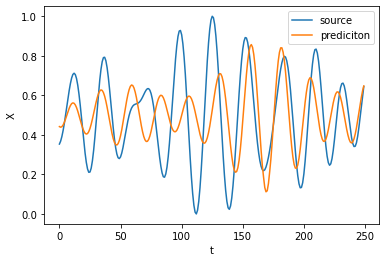

In [ ]:
### Данные, которые мы предсказываем
a = range(0, 250)
plt.figure()
plt.plot(a, trgt_predict1[:, :], label='source')
plt.plot(a, res, label='prediciton')
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.show()

In [ ]:
a = pd.DataFrame(histories.history)
a.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,57.000000,57.000000,57.000000,57.000000
mean,0.061288,0.237965,0.050197,0.113018
std,0.030226,0.378963,0.012928,0.295835
min,0.054899,-2.417893,0.045593,-1.925817
25%,0.054999,0.301080,0.047256,0.168576
50%,0.055084,0.315278,0.047683,0.174148
75%,0.055549,0.321844,0.048011,0.181070
max,0.273679,0.330430,0.140103,0.203832


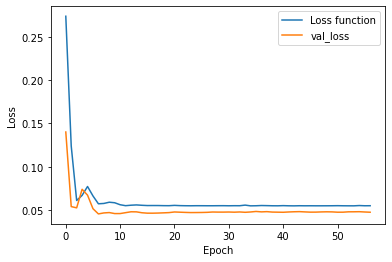

In [ ]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'val_loss')
    plt.legend()
    plt.show()


plot_history(histories)

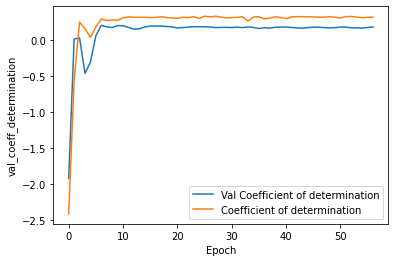

In [ ]:
def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('val_coeff_determination')
    plt.plot(hist['epoch'], hist['val_coeff_determination'],
           label='Val Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.legend()
    plt.show()


plot_history2(histories)

In [ ]:
hist = pd.DataFrame(histories.history)
hist.describe()

,loss,coeff_determination,val_loss,val_coeff_determination
count,500.000000,500.000000,500.000000,500.000000
mean,0.059828,0.220167,0.049665,-1.122677
std,0.017456,0.227248,0.014196,0.132433
min,0.057944,-3.488365,0.047779,-2.852173
25%,0.058019,0.233213,0.047924,-1.161858
50%,0.058068,0.243104,0.048032,-1.136011
75%,0.058149,0.251838,0.048201,-1.110528
max,0.342172,0.271447,0.285604,-0.309772


Проверка нахождения связей

In [ ]:
### Проверка нахождения связей
coefs = {}
for tr in range(15):
    start_time = time.time()
    temp = []
    for i in range(int(math.floor(2/wnd)), int(times/wnd)-1):
        model = baseline_model()
        src = cz_filtered[int(sfq*wnd*i):int(sfq*wnd*(i+1)), tr:tr+1]
        trgt = tp7_filtered[int(sfq*wnd*(i+1)):int(sfq*wnd*(i+2)), tr:tr+1]
        src = normalize(src)
        trgt = normalize(trgt)
        model.fit(src, trgt, epochs=500, batch_size=32, verbose=False, validation_split=0.3)
        src_full = cz_filtered[int(sfq*wnd*i):int(sfq*wnd*(i+1)):5, tr:tr+1]
        trgt_full = tp7_filtered[int(sfq*wnd*(i+1)):int(sfq*wnd*(i+2)):5, tr:tr+1]
        src_full = normalize(src)
        trgt_full = normalize(trgt)
        res = model.predict(src, verbose=False)
        c = r2_score(trgt, res)
#         estimator = KerasRegressor(build_fn=baseline_model, epochs=500, batch_size=32, verbose=0)
#         kfold = KFold(n_splits=10)
#         results = cross_val_score(estimator, src, trgt, cv=kfold)
        temp.append(c)
        print(f'Current trial: {tr} ### Second: {i*wnd}-{(i+1)*wnd} ### R Squared score: {c} ### Time of exec: {time.time() - start_time} seconds')
    coefs[tr] = temp
    print('@@@ New trial @@@')

Current trial: 0 ### Second: 2-3 ### R Squared score: 0.4088807135615681 ### Time of exec: 19.448585987091064 seconds
Current trial: 0 ### Second: 3-4 ### R Squared score: 0.0005522051102755388 ### Time of exec: 38.46012616157532 seconds
Current trial: 0 ### Second: 4-5 ### R Squared score: -0.10405290110376009 ### Time of exec: 57.07137608528137 seconds
Current trial: 0 ### Second: 5-6 ### R Squared score: -0.05323427390892199 ### Time of exec: 75.58541822433472 seconds


KeyboardInterrupt: 

In [ ]:
coefs = list(coefs.values())

In [ ]:
coefs = np.array(coefs)

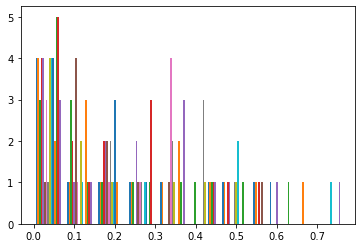

In [ ]:
plt.hist(coefs.T)
plt.show()

In [ ]:
coefs.shape # 15 триалов, в каждом по 9 окон. массив хранит данные о фите для каждого окна

(15, 9)

In [ ]:
len(coefs[0].shape)

1